In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import matplotlib.patches as patches
import math
import numpy as np

In [2]:
class World:
    def __init__(self,time_span,time_interval,debug=False):
        self.objects = []
        self.debug=debug
        self.time_span=time_span
        self.time_interval=time_interval
        
    def append(self,obj):
        self.objects.append(obj)
    
    def draw(self):
        fig=plt.figure(figsize=(4,4))
        ax=fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        ax.set_xlabel("X",fontsize=10)
        ax.set_ylabel("Y",fontsize=19)
        
        elems=[]
        if self.debug:
            for frame in range(int(self.time_span/self.time_interval)): self.one_step(frame,ax,elems)
        
        else:
            self.ani = anm.FuncAnimation(fig=fig,func=self.one_step,frames=int(self.time_span/self.time_interval),fargs=(ax,elems),interval=self.time_interval*1000,repeat=False)
            plt.show()
    
    def one_step(self,frame,ax,elems):
        while elems: elems.pop().remove()
        time_str="t = %.2f[s]" % (self.time_interval*frame)
        elems.append(ax.text(-4.5,4.5,time_str,fontsize=10))
        for obj in self.objects:
            obj.draw(ax,elems)
            if hasattr(obj,"one_step"): obj.one_step(self.time_interval)

In [3]:
class IdealRobot:
    def __init__(self,pose,agent=None,sensor=None,color="black"):
        self.pose=pose
        self.agent=agent
        self.r=0.2
        self.color=color
        self.poses=[pose]
        self.sensor=sensor
        
    def draw(self,ax,elems):
        x,y,theta=self.pose
        self.poses.append(self.pose)
        xn=x+self.r*math.cos(theta)
        yn=y+self.r*math.sin(theta)
        elems+=ax.plot([x,xn],[y,yn],color=self.color)
        c=patches.Circle(xy=(x,y),radius=self.r,fill=False,color=self.color)
        elems.append(ax.add_patch(c))
        elems+=ax.plot([e[0] for e in self.poses],[e[1] for e in self.poses],color="red")
        if self.sensor and len(self.poses) > 1:
            self.sensor.draw(ax,elems,self.poses[-2])
    
    @classmethod
    def state_transition(cls,nu,omega,time,pose):
        t0=pose[2]
        if math.fabs(omega)<1e-10:
            return pose+np.array([nu*math.cos(t0),
                                   nu*math.sin(t0),
                                   omega])*time
        else:
            return pose+np.array([nu/omega*(math.sin(t0+omega*time)-math.sin(t0)),
                                   nu/omega*(-math.sin(t0+omega*time)+math.cos(t0)),
                                   omega*time])
        
    def one_step(self,time_interval):
        if not self.agent:return
        if self.sensor:
            obs=self.sensor.data(self.pose)
        else:
            obs=None
        nu,omega = self.agent.decision(obs)
        self.pose=self.state_transition(nu,omega,time_interval,self.pose)

In [4]:
class Agent:
    def __init__(self,nu,omega):
        self.nu=nu
        self.omega=omega
        
    def decision(self,observation=None):
        return self.nu,self.omega

In [1]:
class Landmark:
    def __init__(self,x,y):
        self.pos = np.array([x,y]).T
        self.id = None
    
    def draw(self,ax,elems):
        elems.append(ax.scatter(self.pos[0],self.pos[1],marker="*",color="orange"))
        elems.append(ax.text(self.pos[0],self.pos[1],"id:"+str(self.id),fontsize=10))

In [ ]:
class Map:
    def __init__(self):
        self.landmarks=[]
    
    def append_landmark(self,landmark):
        landmark.id=len(self.landmarks)
        self.landmarks.append(landmark)
    
    def draw(self,ax,elems):
        for lm in self.landmarks: lm.draw(ax,elems)

In [7]:
class IdealCamera:
    def __init__(self,env_map):
        self.map=env_map
        self.lastdata=[]
        
    def data(self,cam_pose):  #マップ内のランドマークを1つずつ出す。
                              #ランドマークの位置とカメラの位置から、差分を計算する。
                              #距離と方向とidをobservedにtupleで追加する。
                              #各ランドマークのtupleを持ったobservedをlastdataに入れる。
        observed=[]
        for lm in self.map.landmarks:
            z=self.observed_function(cam_pose,lm.pos)
            observed.append((z,lm.id))
        
        self.lastdata = observed
        return observed
    
    @classmethod
    def observation_function(cls,cam_pose,obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi=math.atan2(diff[1],diff[0])-cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff),phi]).T
    
    def draw(self,ax,elems,cam_pose):
        for lm in self.lastdata:
            x,y,theta=cam_pose
            distance,direction=lm[0][0],lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx],[y,ly],color="pink")

<IPython.core.display.Javascript object>


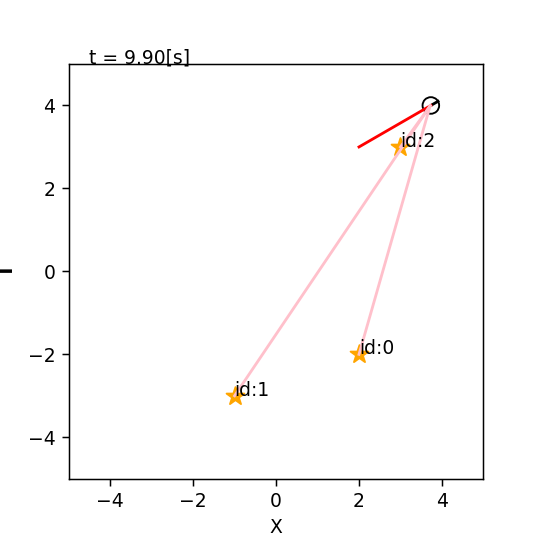

In [8]:
world = World(10,0.1,debug=False)

m=Map()
m.append_landmark(Landmark(2,-2))
m.append_landmark(Landmark(-1,-3))
m.append_landmark(Landmark(3,3))
world.append(m)

straight=Agent(0.2,0.0)
robot1=IdealRobot(np.array([2,3,math.pi/6]).T, sensor=IdealCamera(m),agent=straight)
world.append(robot1)

world.draw()